In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
sentiment_df = pd.read_csv("/content/fear_greed_index.csv")
trader_df = pd.read_csv("")

sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

trader_df['Timestamp IST'] = pd.to_datetime(trader_df['Timestamp IST'], format="%d-%m-%Y %H:%M")

trader_df['trade_date'] = trader_df['Timestamp IST'].dt.date
sentiment_df['date_only'] = sentiment_df['date'].dt.date

merged_df = pd.merge(
    trader_df,
    sentiment_df,
    left_on='trade_date',
    right_on='date_only',
    how='left'  # Keeps all trader data, even if sentiment is missing
)

merged_preview = merged_df[[
    'Account', 'Execution Price', 'Size USD', 'Side', 'Closed PnL',
    'trade_date', 'classification', 'value'
]]

print(merged_preview.head())

                                      Account  Execution Price  Size USD Side  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed           7.9769   7872.16  BUY   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed           7.9800    127.68  BUY   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed           7.9855   1150.63  BUY   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed           7.9874   1142.04  BUY   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed           7.9894     69.75  BUY   

   Closed PnL  trade_date classification  value  
0         0.0  2024-12-02  Extreme Greed   80.0  
1         0.0  2024-12-02  Extreme Greed   80.0  
2         0.0  2024-12-02  Extreme Greed   80.0  
3         0.0  2024-12-02  Extreme Greed   80.0  
4         0.0  2024-12-02  Extreme Greed   80.0  


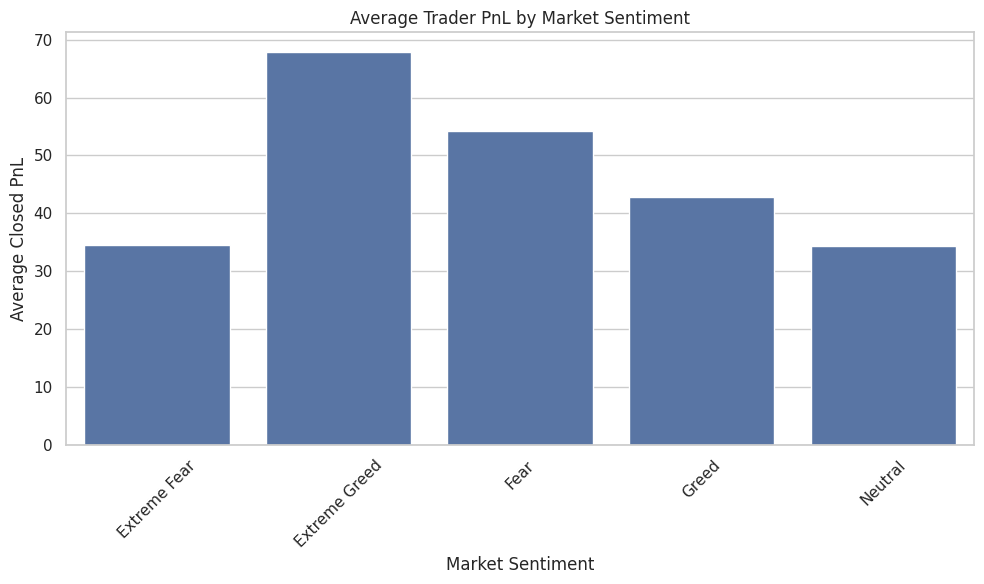

In [5]:
sns.set(style="whitegrid")

summary_stats = merged_df.groupby('classification').agg({
    'Closed PnL': ['mean', 'sum', 'count'],
    'Size USD': 'mean'
}).reset_index()

summary_stats.columns = ['Sentiment', 'Avg PnL', 'Total PnL', 'Number of Trades', 'Avg Trade Size']

# --- Plot 1: Average Closed PnL by Sentiment ---
plt.figure(figsize=(10, 6))
sns.barplot(data=summary_stats, x='Sentiment', y='Avg PnL')
plt.title('Average Trader PnL by Market Sentiment')
plt.ylabel('Average Closed PnL')
plt.xlabel('Market Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

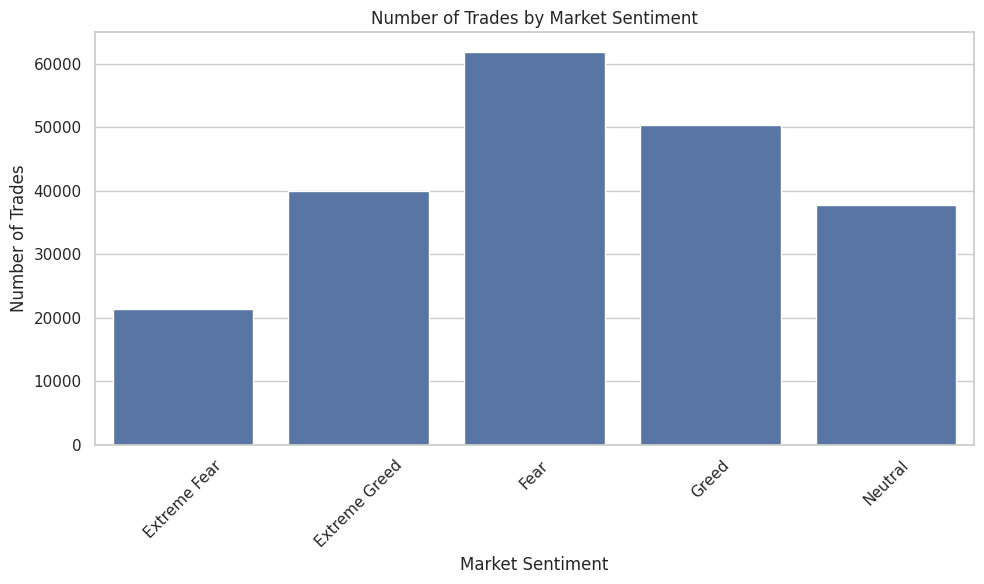

In [6]:
# --- Plot 2: Number of Trades by Sentiment ---
plt.figure(figsize=(10, 6))
sns.barplot(data=summary_stats, x='Sentiment', y='Number of Trades')
plt.title('Number of Trades by Market Sentiment')
plt.ylabel('Number of Trades')
plt.xlabel('Market Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

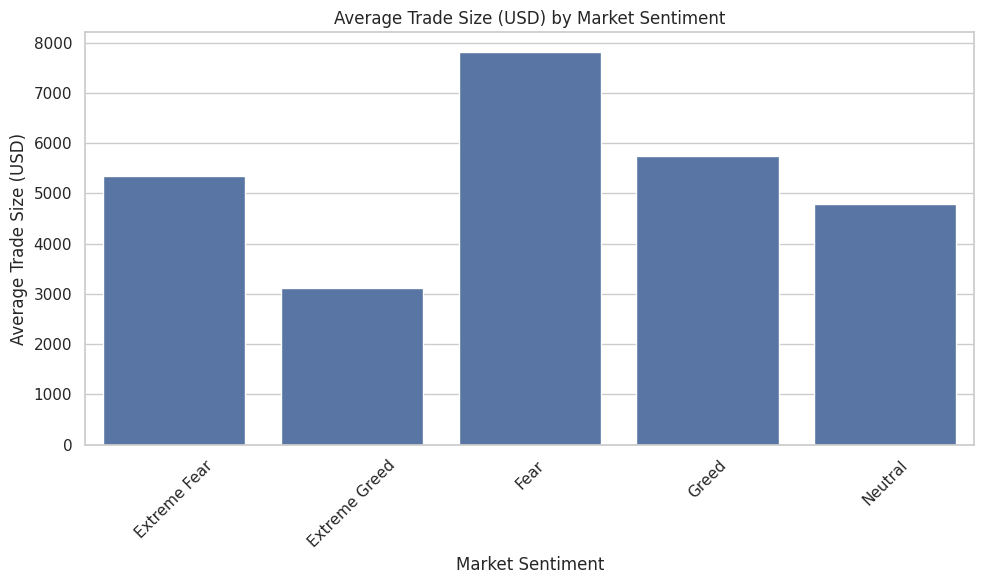

In [7]:
# --- Plot 3: Average Trade Size by Sentiment ---
plt.figure(figsize=(10, 6))
sns.barplot(data=summary_stats, x='Sentiment', y='Avg Trade Size')
plt.title('Average Trade Size (USD) by Market Sentiment')
plt.ylabel('Average Trade Size (USD)')
plt.xlabel('Market Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
# --- 1. Win Rate by Sentiment ---
merged_df['Win'] = merged_df['Closed PnL'] > 0
win_rate_by_sentiment = merged_df.groupby('classification')['Win'].mean().reset_index()
win_rate_by_sentiment.columns = ['Sentiment', 'Win Rate']
print("Win Rate by Sentiment:")
print(win_rate_by_sentiment)

# --- 2. Correlation between Sentiment Score and Closed PnL ---
correlation = merged_df[['value', 'Closed PnL']].corr().iloc[0, 1]
print("\nCorrelation between Sentiment Value and Closed PnL:", correlation)

# --- 3. Summary by Sentiment and Side ---
side_sentiment_summary = merged_df.groupby(['classification', 'Side']).agg({
    'Closed PnL': ['mean', 'sum'],
    'Size USD': 'mean',
    'Win': 'mean'
}).reset_index()

# --- 4. T-test: Compare PnL between Extreme Fear and Extreme Greed ---
fear_pnl = merged_df[merged_df['classification'] == 'Extreme Fear']['Closed PnL']
greed_pnl = merged_df[merged_df['classification'] == 'Extreme Greed']['Closed PnL']

t_stat, p_value = ttest_ind(fear_pnl, greed_pnl, equal_var=False)

print("\nT-test Result between Extreme Fear and Extreme Greed PnL:")
print("t-statistic:", t_stat)
print("p-value:", p_value)

Win Rate by Sentiment:
       Sentiment  Win Rate
0   Extreme Fear  0.370607
1  Extreme Greed  0.464943
2           Fear  0.420768
3          Greed  0.384828
4        Neutral  0.396991

Correlation between Sentiment Value and Closed PnL: 0.008120513598320127

T-test Result between Extreme Fear and Extreme Greed PnL:
t-statistic: -3.8511675429271293
p-value: 0.00011778426575866563


In [14]:
# Grouping trader behavior by sentiment classification
trader_summary = merged_df.groupby(['Account', 'classification']).agg({
    'Closed PnL': 'mean',
    'Size USD': 'mean',
    'Win': 'mean'
}).unstack().fillna(0)

# Flatten MultiIndex
trader_summary.columns = ['_'.join(col).strip() for col in trader_summary.columns.values]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(trader_summary)

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
trader_summary['Cluster'] = kmeans.fit_predict(X_scaled)

# View cluster counts
print(trader_summary['Cluster'].value_counts())

Cluster
1    24
0     7
2     1
Name: count, dtype: int64


In [16]:
# Prepare dataset
model_df = merged_df[['value', 'Size USD', 'Side', 'Win']].dropna()
model_df['Side'] = model_df['Side'].map({'BUY': 1, 'SELL': 0})  # Encode Side

# Features and target
X = model_df[['value', 'Size USD', 'Side']]
y = model_df['Win']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Prediction and evaluation
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.77      0.77      0.77     31089
        True       0.67      0.67      0.67     21716

    accuracy                           0.73     52805
   macro avg       0.72      0.72      0.72     52805
weighted avg       0.73      0.73      0.73     52805



/tmp/ipython-input-4058397814.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim_df['Day'] = sim_df['trade_date']


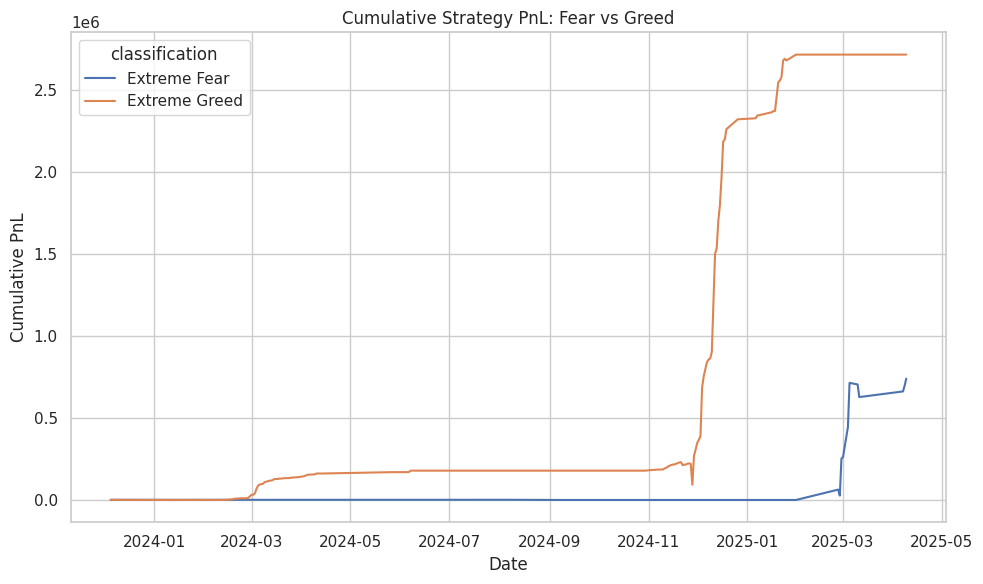

In [17]:
# Filter only fear/greed trades
sim_df = merged_df[merged_df['classification'].isin(['Extreme Fear', 'Extreme Greed'])]
sim_df['Day'] = sim_df['trade_date']

# Cumulative PnL per sentiment
sim_cumulative = sim_df.groupby(['Day', 'classification'])['Closed PnL'].sum().unstack().fillna(0)
sim_cumulative = sim_cumulative.cumsum()

# Plot cumulative PnL
sim_cumulative.plot(figsize=(10, 6), title='Cumulative Strategy PnL: Fear vs Greed')
plt.ylabel('Cumulative PnL')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()